### Exploring Chemical and Biological Data With BidingDB and the RDKit
In this notebook we will use the [BindingDB](https://bindingdb.org/rwd/bind/index.jsp), database of chemical structures and biological activity values extracted from the chemical literature, to search for compounds that bind to the SARS-CoV-2 main  protease. (https://en.wikipedia.org/wiki/P38_mitogen-activated_protein_kinases).  In addition to hosting data from the scientifiic literature, BindingDB also has data extracted from chemical patents.  We will extract the data from a SARS-CoV-2 inhibitor patent, explore this data, and save a representative subset for a subsequent docking analysis. 

### 1. Searching BindingDB and Downloading Chemical Structures and Data
We begin by accessing the BindingDB website at [https://bindingdb.org](https://bindingdb.org). Click on the **Publications** link on the left, then click on the **US Patent** link. 
   
<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/refs/heads/main/pdb/binding_db_01.png"/>     
   
This will bring up a results page like the one below.  This page shows recently curated patents and allows us to search by patent number.  Enter this text into the box, [US20240293380](https://patents.google.com/patent/US20240293380A1/fr).  Once you click on the **Search** button, BindingDB will find compounds that were curated from this patent by scientists as the Cleveland Clinic, describing a set of protease inhibitors. 
   
<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/refs/heads/main/pdb/binding_db_02.png"/>  
   
This will take you to a page with details the 75 compounds extracted from US20240293380.  The page shows chemical structures as well as links to other databases. To download the information about all structures from this patent, first click on the **Add all pages** link, followed by the **Make dataset** button indicated by the arrows in figure below. 
   
<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/refs/heads/main/pdb/binding_db_03.png"/>   
   
By selecting the **Tab Delimited (TSV)** radio button and pressing the **Go** button, we can download the data.  This download requires registration with BindingDB.  To streamline this tutorial, we will load the file directly from GitHub instead. 
   
<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/refs/heads/main/pdb/binding_db_04.png"/>    

### 2. Import the necessary Python libraries

In [1]:
import pandas as pd
import mols2grid
import seaborn as sns
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdFMCS
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
import useful_rdkit_utils as uru
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import jscatter
import ipywidgets
import io
import matplotlib.pyplot as plt
import base64
from IPython.display import HTML
from rdkit.Chem.Draw import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

### 3. Read the file we downloaded from PDBBind into a Pandas dataframe. 

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/refs/heads/main/pdb/monomers_12285.tsv",sep="\t")

As we can see, the data we extracted from BindingDB has many fields. 

In [3]:
df.columns

Index(['BindingDB Reactant_set_id', 'Ligand SMILES', 'Ligand InChI',
       'Ligand InChI Key', 'BindingDB MonomerID', 'BindingDB Ligand Name',
       'Target Name',
       'Target Source Organism According to Curator or DataSource', 'Ki (nM)',
       'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'kon (M-1-s-1)', 'koff (s-1)',
       'pH', 'Temp (C)', 'Curation/DataSource', 'Article DOI',
       'BindingDB Entry DOI', 'PMID', 'PubChem AID', 'Patent Number',
       'Authors', 'Institution', 'Link to Ligand in BindingDB',
       'Link to Target in BindingDB',
       'Link to Ligand-Target Pair in BindingDB', 'Ligand HET ID in PDB',
       'PDB ID(s) for Ligand-Target Complex', 'PubChem CID of Ligand',
       'PubChem SID of Ligand', 'ChEBI ID of Ligand', 'ChEMBL ID of Ligand',
       'DrugBank ID of Ligand', 'IUPHAR_GRAC ID of Ligand',
       'KEGG ID of Ligand', 'ZINC ID of Ligand',
       'Number of Protein Chains in Target (>1 implies a multichain complex)',
       'BindingDB Target Chain Sequ

To make things simpler, we'll rename a couple of columns.

In [4]:
df.rename(columns={'Ligand SMILES':'SMILES'},inplace=True)
df.rename(columns={'BindingDB Ligand Name':'Name'},inplace=True)

We can aslo see that the data has 75 rows, with each compound corresponding to a row.  For our purposes, we'll focus on a few fields. 
- SMILES - the chemical structure of the compound
- Name - the internal identifier Binding DB provides for each compund
- IC50 (nM) - the IC50 in nM.

In [5]:
len(df)

75

We can use [mols2grid](https://github.com/cbouy/mols2grid) to browse the chemcial structures of the 75 compounds. 

In [6]:
mols2grid.display(df,smiles_col="SMILES",subset=["img","IC50 (nM)"])

MolGridWidget()

### 3. Visualizing the Activity Distribution
Let's look at the the IC50 distribution for the 75 compounds.  As we can see below, the default view isn't very helpful. 

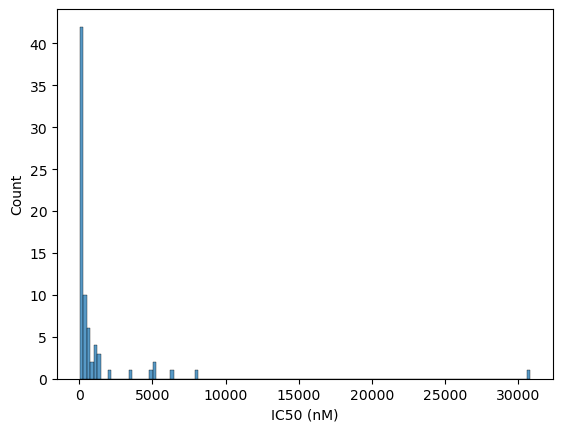

In [7]:
ax = sns.histplot(df["IC50 (nM)"])

It's oftent easier to look at the distribution of **pIC50** values, where pIC50 is the negative log of the IC50. 

In [8]:
df["pIC50"] = -np.log10(df["IC50 (nM)"] * 1e-9)

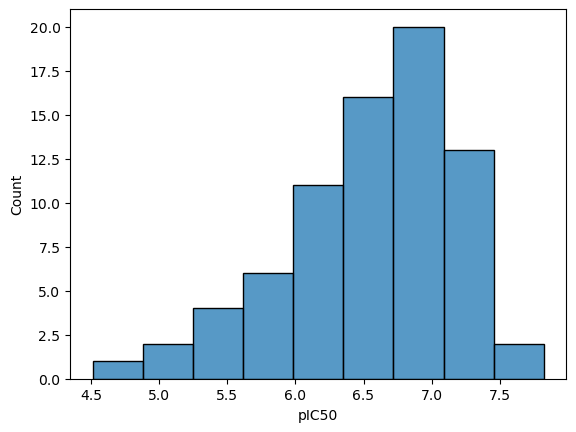

In [9]:
ax = sns.histplot(df.pIC50)

For visualization it's often helpful to bin the activity into high, medium, and low bins.  Here well put compounds with 6 < pIC50 < 7 (0.1-1$\micro$M) into the "medium" bin, and compounds with pIC50 > 7 into the "high" bin. 

In [10]:
df["activity"] = pd.cut(df.pIC50,bins=[0,6,7,100],labels=["low","med","high"],right=False)

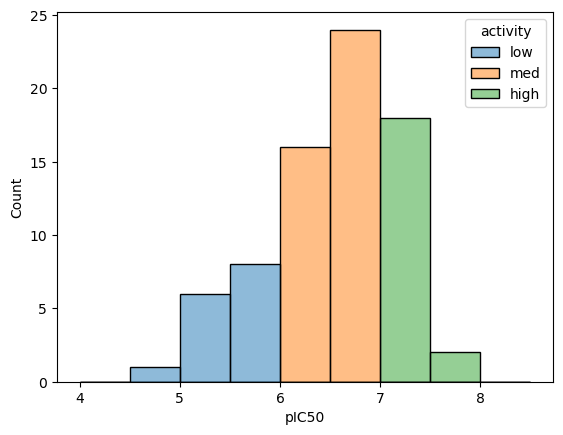

In [11]:
ax = sns.histplot(x="pIC50",hue="activity",data=df,bins=np.arange(4,9,0.5))

### 4. Visulaizing Chemical Space 
Visualizing the chemical space for a set of compounds coloring by activity can often help us to understand the relationships between chemical structure and biological activity.  In this section we will use t-Distributed Stochastic Neighbor Embedding (**tSNE**) to visualize the chemical space covered by the 75 compounds we extracted from BindingDB.  To construct this visualization, we will beging by generating a chemical fingerprint for each compound.  We will then use Principal Component Analysis (PCA) to reduce the dimesionality of the fingerprints from 2048 to 50 dimensions.  The 50-dimensional PCA representation will then be projected into two dimensions with tSNE.  

To generate the fingerprints, we begin by instantiating a fingerprint generator object from useful_rdkit_utils, a library of useful chemistry functions. This object simplifies the generation of chemical fingerprints with the RDKit Python library. 

In [12]:
smi2fp = uru.Smi2Fp()

We can the use the Pandas apply function to add the fingerprints to out dataframe.  The **get_np** method generates fingerprints as a numpy array.  This format is widely used in machine learning applications. 

In [13]:
df['fp'] = df["SMILES"].apply(smi2fp.get_np)

Next we use PCA to reduce the fingerprint from 2048 to 50 dimensions.  

In [14]:
pca = PCA(n_components=50)
pcs = pca.fit_transform(np.stack(df.fp))

Finally we use tSNE to generate a two-dimensional representation of chemical space. 

In [15]:
tsne = TSNE(n_components=2)
df[["tsne_X","tsne_Y"]] = tsne.fit_transform(pcs)

The tSNE calculation generates a set of 2D coordinates representing the chemical space covered by the 75 compounds.  Similar compounds will be close together in this space, while compounds that are more different will be farther apart.  To understand these relationships, we will create an interactive visualization using the [jupyter-scatter](https://github.com/flekschas/jupyter-scatter) Python library.  If we select a set of points in this visualization, the corresponding chemical structures and associated IC50 values will be shown below the plot. 

The figure below explains the buttons on the left side of jupyter-scatter component. 
<img src="jupyter_scatter_controls.png" style="width: 50%; height: 50%">

In [16]:
scatter = jscatter.Scatter(data=df,x="tsne_X", y="tsne_Y",color_by="activity")
output = ipywidgets.Output()

@output.capture(clear_output=True)
def selection_change_handler(change):
    display(mols2grid.display(df.loc[change.new].head(25),subset=["img","Name","IC50 (nM)"],template="static",prerender=True,size=(200,200)))
            
scatter.widget.observe(selection_change_handler, names=["selection"])

ipywidgets.VBox([scatter.show(), output])

### 5. Understaning the Chemistry in the Downloaded Molecules 
The plot above provide a useful means of exploring the 75 molecules we extracted from a patent in BindingDB.  In addition to this plot, a several Cheminformatics tools can aid or exploratory data analysis. As a first step in this analysis, it can be useful to see which parts are common to all 75 of the molecules.  To do this, we can use the Maxiumum Common Substructure (MCS) capability in the RDKit.  To use this capability, we must first convert the SMILES in our dataframe to RDKit molecule objects.  As above, we can use the Pandas apply method to do this. 

In [17]:
df['mol'] = df["SMILES"].apply(Chem.MolFromSmiles)

Next we can calculate the MCS. 

In [18]:
mcs = rdFMCS.FindMCS(df.mol)

To visualize the MCS, we have to convert it to an RDKit molecule object. 

In [19]:
pat = Chem.MolFromSmarts(mcs.smartsString)

Now we can map the MCS on to the first molecule in the dataframe and display it as a red highlight. 

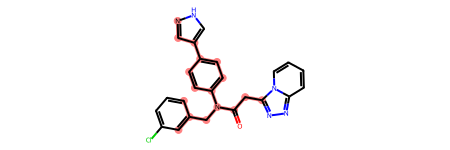

In [20]:
df.mol.values[0].GetSubstructMatch(pat)
df.mol.values[0]

Another tool for exploring chemical datasets is the Bemis-Murcko scaffold. In this technique a molecule is reduced to a set of connected rings and linkers.  We can use the **GetScaffoldForMol**  method from the RDKit to generate Bemis-Murcko scaffolds.  

In [21]:
df['Scaffold'] = df.mol.apply(GetScaffoldForMol)

The generated scaffolds are RDKit molecule objects.  We would like to find the most frequently occuring scaffolds.  To do this, we need to convert the scaffolds to SMILES.  

In [22]:
df['Scaffold_SMILES'] = df.Scaffold.apply(Chem.MolToSmiles)

Now we can us the Pandas **value_counts** method to find the most frequently occuring scaffolds. 

In [23]:
df.Scaffold_SMILES.value_counts()

Scaffold_SMILES
O=C(Cc1cncc2ccccc12)N(Cc1ccccc1)c1ccc(-c2c[nH]cn2)cc1       16
O=C(Cc1cccnc1)N(Cc1ccccc1)c1ccc(-c2c[nH]cn2)cc1             10
O=C(Cc1nnc2ccccn12)N(Cc1ccccc1)c1ccc(-c2c[nH]cn2)cc1         7
O=C(Cc1cncc2ccccc12)N(Cc1ccccc1)c1ccc(C2=CCNC2)cc1           3
O=C(Cc1cncc2ccccc12)N(Cc1ccccc1)c1ccccc1                     3
O=C(Cc1cncc2ccccc12)N(Cc1cccnc1)c1ccc(-c2c[nH]cn2)cc1        3
O=C(Cc1cncc(C2CC2)c1)N(Cc1ccccc1)c1ccc(-c2c[nH]cn2)cc1       2
O=C(Cc1cncc2ccccc12)N(Cc1ccccc1)c1ccc(C2CNC2)cc1             2
O=C(Cc1nnc2cccnn12)N(Cc1ccccc1)c1ccc(-c2c[nH]cn2)cc1         2
O=C(Cc1nnc2ccccn12)N(Cc1ccccc1)c1ccc(-c2cn[nH]c2)cc1         2
O=C(Cc1cccnn1)N(Cc1ccccc1)c1ccc(-c2c[nH]cn2)cc1              2
O=C(Cc1cnccn1)N(Cc1ccccc1)c1ccc(-c2c[nH]cn2)cc1              1
O=C(Cc1cncc2ccccc12)N(Cc1cccnc1)c1ccc(C2=CCNC2)cc1           1
O=C(Cc1nncc2ccccc12)N(Cc1ccccc1)c1ccc(-c2c[nH]cn2)cc1        1
O=C(Cc1cncc(C2CC2)c1)N(Cc1ccccc1)c1ccc(C2CNC2)cc1            1
O=C(Cc1cccnc1)N(Cc1ccccc1)c1ccc(C2CNC2)

Let's take a closer look at the most frequent scaffolds.  We can use the Pandas **query** method to find scaffolds that occur in at least 5 molecules.  

In [24]:
uru.value_counts_df(df,"Scaffold_SMILES").query("count > 5")

,Scaffold_SMILES,count
0,O=C(Cc1cncc2ccccc12)N(Cc1ccccc1)c1ccc(-c2c[nH]...,16
1,O=C(Cc1cccnc1)N(Cc1ccccc1)c1ccc(-c2c[nH]cn2)cc1,10
2,O=C(Cc1nnc2ccccn12)N(Cc1ccccc1)c1ccc(-c2c[nH]c...,7


Next we would like to visualize these scaffolds along with their associated IC50 distributions.  To do this, we will define two plotting functions to generate images.  We will then put the resulting images into a Pandas dataframe and visualize the results. 

In [25]:
def boxplot_base64_image(dist: np.ndarray, x_lim: list[int] = [0, 10]) -> str:
    """
    Plot a distribution as a seaborn boxplot and save the resulting image as a base64 image.

    Parameters:
    dist (np.ndarray): The distribution data to plot.
    x_lim (list[int]): The x-axis limits for the boxplot.

    Returns:
    str: The base64 encoded image string.
    """
    sns.set(rc={'figure.figsize': (3, 1)})
    sns.set_style('whitegrid')
    ax = sns.boxplot(x=dist)
    ax.set_xlim(x_lim[0], x_lim[1])
    s = io.BytesIO()
    plt.savefig(s, format='png', bbox_inches="tight")
    plt.close()
    s = base64.b64encode(s.getvalue()).decode("utf-8").replace("\n", "")
    return '<img align="left" src="data:image/png;base64,%s">' % s


def mol_to_base64_image(mol: Chem.Mol) -> str:
    """
    Convert an RDKit molecule to a base64 encoded image string.

    Parameters:
    mol (Chem.Mol): The RDKit molecule to convert.

    Returns:
    str: The base64 encoded image string.
    """
    drawer = rdMolDraw2D.MolDraw2DCairo(300, 150)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    text = drawer.GetDrawingText()
    im_text64 = base64.b64encode(text).decode('utf8')
    img_str = f"<img src='data:image/png;base64, {im_text64}'/>"
    return img_str

In [26]:
output_list = []
for k,v in df.groupby('Scaffold_SMILES'):
    if len(v) > 5:
        mol = Chem.MolFromSmiles(k)
        mol_image = mol_to_base64_image(mol)
        boxplot_image = boxplot_base64_image(v.pIC50.values)
        output_list.append([mol_image, len(v),boxplot_image])
output_df = pd.DataFrame(output_list,columns=["Scaffold","Num Examples","pIC50 Distribution"])        

With the dataframe generated above, we can now visualize the activity distributions associated with the three most common scaffolds. 


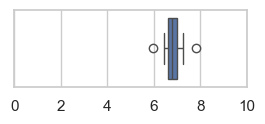
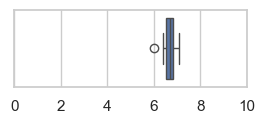
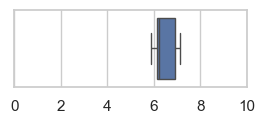

In [27]:
HTML(output_df.sort_values("Num Examples",ascending=False).to_html(escape=False))

### 6. Select and Export a Subset of the 75 Compounds for Docking
As the next part of this tutorial, we'll dock a few of the 75 molecules we extracted into a protein crystal structure of p38 kinase. Since we have limited commputational resources available, we will use clustering to select a subset of the compounds.   Clustering uses chemical fingerprits to group similar chemical structures.  In this case, we will use the Butina clustering algorithm as implemented in the RDKit.  To perform the clustering, we need to generate a different chemical fingerprint format than the one we generated above when we were performing dimensionality reduction. In this case, we will use the **get_fp** method of the useful_rdkit_utils Smi2Fp class.  

In [28]:
df['morgan_fp'] = df.SMILES.apply(smi2fp.get_fp)

With the fingerprint generated, we can cluster using the **taylor_butina_clustering** convenience function in useful_rdkit_utils. This adds a new field, "cluster" to the dataframe. 

In [29]:
df['cluster'] = uru.taylor_butina_clustering(df.morgan_fp)

As we did above, we can use the Pandas **value_counts** method to see how many compounds are in each cluster. The vast majority of compounds are in cluster 0. 

In [30]:
df.cluster.value_counts()

cluster
0    65
1     4
4     4
2     1
3     1
Name: count, dtype: int64

Let's select the most active compound from each cluster.  To do this we first sort the dataframe by "IC50 (nM)".  Once the dataframe is sorted, we can use the Pandas **drop_duplicates** methood to delete all but the first compound from each cluster. 

In [31]:
unique_cluster_df = df.sort_values("IC50 (nM)").drop_duplicates("cluster").copy()

Now we'd like to exort these 5 compounds as a csv file.  The dataframe contains a lot of columns, most of which we don't need.  Let's creat a list of the columns we'd like to export. 

In [32]:
columns_to_keep = ["SMILES","Name","IC50 (nM)","cluster"]

View these columns to ensure this is what we want. 

In [33]:
unique_cluster_df[columns_to_keep].sort_values("cluster")

,SMILES,Name,IC50 (nM),cluster
9,Fc1cc(Cl)cc(CN(C(=O)Cc2cncc3ccccc23)c2ccc(cc2)...,"US20240293380, Compound 12",15.0,0
0,Clc1cccc(CN(C(=O)Cc2nnc3ccccn23)c2ccc(cc2)-c2c...,"US20240293380, Compound 1",365.0,1
54,CC(C)(C)NC(=O)C(N(C(=O)Cc1cncc2ccccc12)c1ccc(c...,"US20240293380, Compound 63",1027.0,2
74,Fc1cncc(CN(C(=O)Cc2cncc(F)c2)c2ccc(cc2)C2CNC2)c1,"US20240293380, Compound 83",5225.0,3
3,Clc1cccc(CN(C(=O)Cc2cnc3ccccn23)c2ccc(cc2)-c2c...,"US20240293380, Compound 4",1146.0,4


Finally, export the five molecules as a csv file. 

In [34]:
unique_cluster_df[columns_to_keep].sort_values("cluster").to_csv("US20240293380_examples.csv",index=False)

These structures can be docked into the PDB structure [7LME](https://www.rcsb.org/structure/7lme) of the SARS-CoV-2 3CLPro. For more information on compounds similar to those in US20240293380, please see ["Structure-Based Optimization of ML300-Derived, Noncovalent Inhibitors Targeting the Severe Acute Respiratory Syndrome Coronavirus 3CL Protease (SARS-CoV-2 3CLpro)"](https://pubs.acs.org/doi/10.1021/acs.jmedchem.1c00598)